# Multivariate Bernoulli Distribution
Notebook can be found in github: https://github.com/deepakhr1999/SPR_A3/blob/main/SPR%20Lab%203.ipynb

Run EM and K-Means algorithm on same dataset and compare the results.

## Reading MNIST dataset 

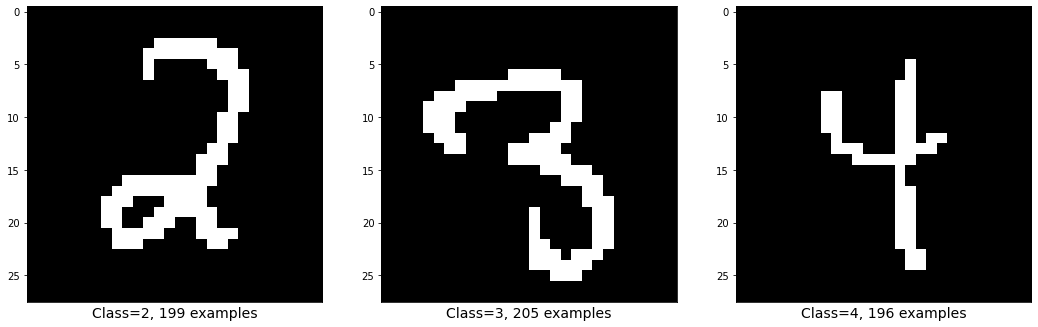

In [1]:
import numpy as np
import torch
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
np.random.seed(42)

class Config:
    N = 600
    K = 3
    D = 784
    iterations = 50
    
def load_mnist():
    mnist = pd.read_csv('mnist600.csv').values
    X_train, y_train = mnist[:, 1:], mnist[:, 0]
    
    # show one example from each class
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, c in enumerate([2, 3, 4]):
        img = X_train[y_train == c][0].reshape((28, 28))
        t = (y_train==c).sum()
        axs[i].imshow(img, cmap='CMRmap')
        axs[i].set(xticks = [])
        axs[i].set_xlabel(f"Class={c}, {t} examples", fontsize=14)        
    plt.show()
    return X_train, y_train

X_train, y_train = load_mnist()

## EM algorithm for Multivariate Bernoulli Mixture
One iteration of EM updates $\pi_k$ and $\mu_k$ as follows

$P(x|\mu_k) = \prod_{i=1}^{D}\mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}$

$\gamma_{nk} = \frac{\pi_k P(x_n|\mu_k)}{\sum_{j=1}^{K}\pi_j P(x_n|\mu_j)}$

$N_k = \sum_{n=1}^{N}\gamma_{nk}$

$\mu_k = \frac{\sum_{n=1}^{N}\gamma_{nk}x_n}{N_k}$

In [2]:
class BernoulliMixtureModel:
    def __init__(self):
        self.pi = np.ones((Config.K,1)) / Config.K  # pi_k
        self.mu = np.random.uniform(low=.25, high=.75, size=(Config.K, Config.D)) # mu_kj
        self.mu /= self.mu.sum(axis=1, keepdims=True) # sum mu_kj over j should be 1
    
    # helpers
    def prob(self, X_nd, k): # examples, k -> [P(example | k)]
        mu_1d = self.mu[k:k+1]
        p_nd = mu_1d**X_nd * (1- mu_1d)**(1-X_nd) #(1, d)*(n, d)
        p_n = np.prod(p_nd, axis=1) # product over dimensions, axis=1
        return p_n

    def getGamma(self, X_nd):
        g_kn = np.array([
            self.pi[k, 0] * self.prob(X_nd, k)
            for k in range(Config.K)
        ]) # (k n)
        
        denom = g_kn.sum(axis=0, keepdims=True)
        denom[denom == 0.0] = 1
        g_kn /= denom # sum over clusters (k) must be one

        return g_kn, denom
    
    def oneIteration(self, X_nd):
        """Performs one iteration of the EM algorithm for bernoulli mix model
        Args
            * X_nd is an np.array with n examples, each of d dimensions
        Function
            * updates Params.mu and Params.pi
        """
        g_kn, denom = self.getGamma(X_nd)

        # N_k is gamma summed over n
        N_k = g_kn.sum(axis=1, keepdims=True) # shape (k,)

        # new mu is examples averaged over gamma
        mu_kd = np.matmul(g_kn, X_nd)
        self.mu = mu_kd / N_k
        self.pi = N_k / Config.N

        # return log likelihood
        return - np.log(denom).sum()
    
    def fit(self, X_train):
        return [
            self.oneIteration(X_train)
            for i in range(Config.iterations)
        ]

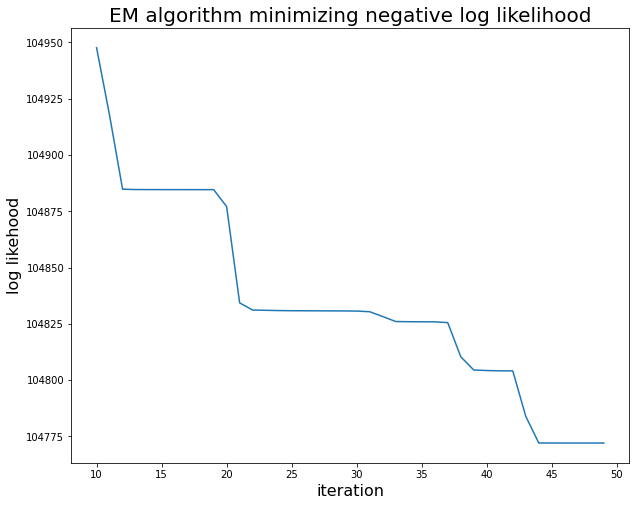

In [3]:
model = BernoulliMixtureModel()
neg_log_likelihoods = model.fit(X_train)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(10, Config.iterations), neg_log_likelihoods[10:])
ax.set_ylabel('log likehood', fontsize=16)
ax.set_xlabel('iteration', fontsize=16)
ax.set_title('EM algorithm minimizing negative log likelihood', fontsize=20);

## Most likely estimate for Single Multivariate Bernoulli
$Z = [z_i] \in R^d$

$Z_{mle} = \frac{\sum_{n=1}^{N}X_i}{N}$

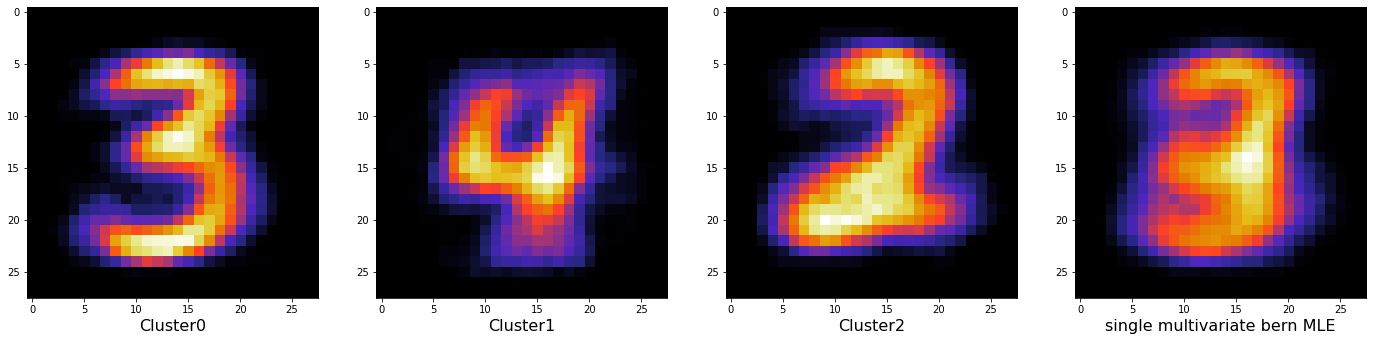

In [4]:
# display EM algo mus
images = (model.mu * 255).reshape((Config.K, 28, 28)).astype(np.uint8)
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for k in range(Config.K):
    axs[k].imshow(images[k], cmap='CMRmap')
    axs[k].set_xlabel(f'Cluster{k}', fontsize=16)

img = (X_train.mean(axis=0) * 255).reshape((28, 28)).astype(np.uint8)
axs[Config.K].imshow(img, cmap='CMRmap')
axs[Config.K].set_xlabel('single multivariate bern MLE', fontsize=16)
plt.show()

In [ ]:
%%sql
with ht as 
    (SELECT  uuid, profile_type, booking_id, date_part, lob, booking_date, booking_time, company_flag, booking_status, sellamount, costamount,
                      total_discount_amount, device_type, device_os, customer_type, payment_mode, locus_to_city, is_pilgrimage_city, booking_cancel_status,
                      date(from_unixtime(htl_checkin_datets/1000)) AS checkin_dt, date(from_unixtime(htl_checkout_datets/1000)) AS checkout_dt
                FROM dpt_master.booking_master_delta
                WHERE (is_booking_offline = FALSE
                      OR is_booking_offline IS NULL)
                  AND lower(booking_status) IN ('confirmed','cancelled','partial')
                  AND date_part>='2021-01-01' AND date_part<'2021-03-01'
                  and CAST(date(from_unixtime(htl_checkin_datets/1000)) AS varchar) >= '2021-01-01' -- checkin_dt
                  and cast(date(from_unixtime(htl_checkin_datets/1000)) as varchar) < '2021-03-01' -- checkin_dt
                  AND lob_part='hotels'),
    fl as (SELECT  uuid, profile_type, booking_id, date_part, lob, booking_date, booking_time, company_flag, booking_status, sellamount, costamount,
                      total_discount_amount, device_type, device_os, customer_type, payment_mode, locus_to_city, is_pilgrimage_city, booking_cancel_status,
                      date(from_unixtime(flt_departure_datets/1000)) AS checkin_dt, date(from_unixtime(flt_return_datets/1000)) AS checkout_dt
                FROM dpt_master.booking_master_delta
                WHERE (is_booking_offline = FALSE
                      OR is_booking_offline IS NULL)
                  AND lower(booking_status) IN ('confirmed','cancelled','partial')
                  AND date_part>='2021-01-01' AND date_part<'2021-03-01'
                  and CAST(date(from_unixtime(flt_departure_datets/1000)) AS varchar) >= '2021-01-01' -- checkin_dt
                  and cast(date(from_unixtime(flt_departure_datets/1000)) as varchar) < '2021-03-01' -- checkin_dt
                  AND lob_part='flights'),
    ca as (SELECT  uuid, profile_type, booking_id, date_part, lob, booking_date, booking_time, company_flag, booking_status, sellamount, costamount,
                      total_discount_amount, device_type, device_os, customer_type, payment_mode, locus_to_city, is_pilgrimage_city, booking_cancel_status,
                     date(cab_departure_date) AS checkin_dt, date(cab_return_date) AS checkout_dt
            FROM dpt_master.booking_master_delta
            WHERE (is_booking_offline = FALSE
                  OR is_booking_offline IS NULL)
                  AND lower(booking_status) IN ('confirmed','cancelled','partial')
                  AND date_part>='2021-01-01' AND date_part<'2021-03-01'
                  and cab_departure_date >= '2021-01-01' -- checkin_dt
                  and cab_departure_date < '2021-03-01' -- checkin_dt
                  AND lob_part='cabs')
select * from (select * from ht
union all select * from fl
union all select * from ca)

## K-means clustering for MNIST

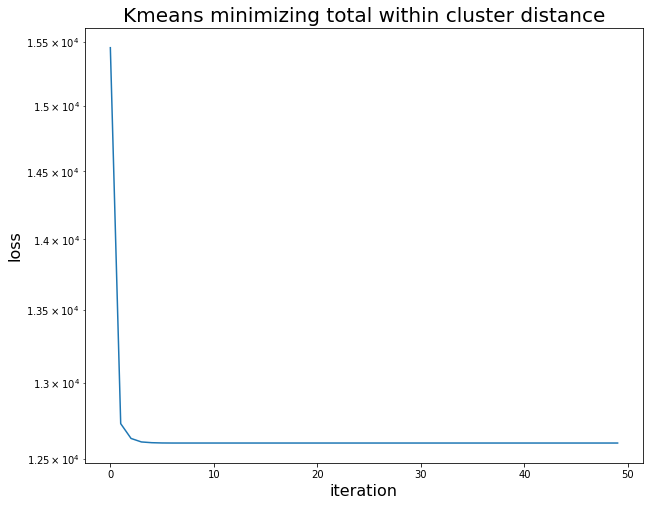

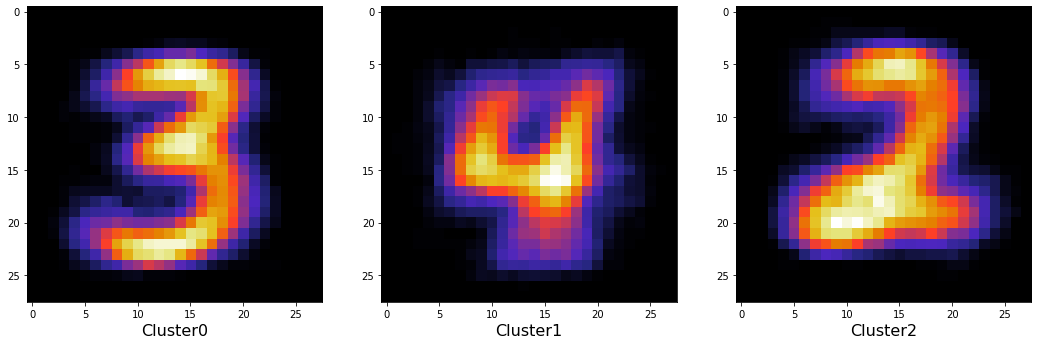

In [5]:
class Kmeans:
    # standardize data
    def standardize(self, X_train):
        sigma = X_train.std(axis=0, keepdims=True)
        sigma[sigma == 0] = 1
        X_stan = X_train  / sigma
        return X_stan, sigma
    
    def fit(self, X_train):
        # init means as K random points from data
        X_stan, sigma = self.standardize(X_train)
        idx  = np.random.choice(np.arange(Config.N), Config.K)
        self.mu = X_stan[idx] * 1.0

        # init assign
        z_n  = np.random.choice(np.arange(Config.K), Config.N)

        losses = []
        for i in range(Config.iterations):
            # calc pairwise dists (ND - K1D -> KN shapes for ref)
            d_kn = np.linalg.norm(X_stan - self.mu[:,None,:], axis=-1)
            # assign cluster based on proximity
            z_n  = d_kn.argmin(axis=0) # N
            losses.append(d_kn.min(axis=0).sum())

            # update cluster means
            z_kn = np.eye(3)[:, z_n] # 3 N
            z_kn/= z_kn.sum(axis=1, keepdims=True) # normalize
            self.mu = z_kn @ X_stan
        
        self.mu = self.mu * sigma
        return losses
    
    def predict(self, X):
        d_kn = np.linalg.norm(X - self.mu[:,None,:], axis=-1)
        # assign cluster based on proximity
        z_n  = d_kn.argmin(axis=0) # N
        return z_n
    
    def plot(self, losses, display_means=True):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(range(Config.iterations), losses)
        ax.set_ylabel('loss', fontsize=16)
        ax.set_xlabel('iteration', fontsize=16)
        ax.set_title('Kmeans minimizing total within cluster distance', fontsize=20)
        plt.yscale('log')
        plt.show()

        # display the k means
        if display_means:
            images = (model.mu * 255).reshape((Config.K, 28, 28)).astype(np.uint8)
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            for k in range(Config.K):
                axs[k].imshow(images[k], cmap='CMRmap')
                axs[k].set_xlabel(f'Cluster{k}', fontsize=16)
            plt.show()
    
model = Kmeans()
losses = model.fit(X_train)
model.plot(losses)

# GMM on custom data
Sample data from univariate and multivariate Gaussian Mixture Models and verify whether EM algorithm is able to retrieve the mixture densities in each of the case.

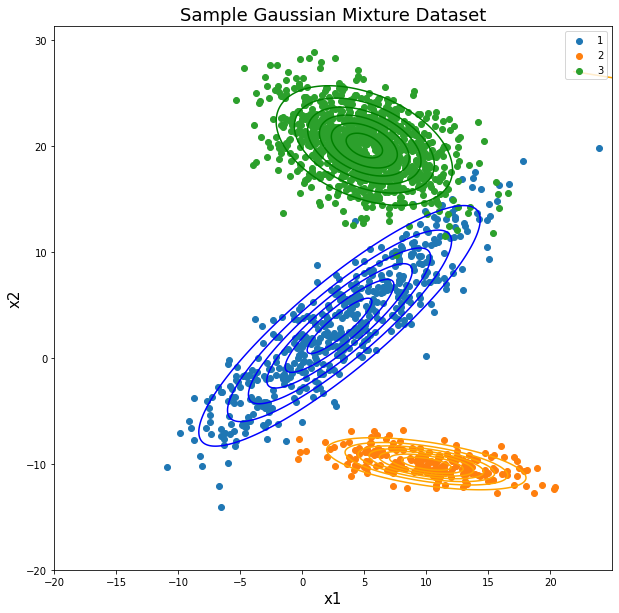

In [6]:
# Config has hardcoded values and are not meant to be changed at all for this notebook
class Config:
    N = 1700
    K = 3 # theser
    D = 2 # dont change this we need 2d for interpretting plots
    iterations = 75
    eps = 1e-3
    
class Actual:
    mu = np.array([[3,3], [10, -10], [5, 20]])
    cov_norot = [
        [[4, 0], [0, 64]],
        [[16, 0], [0, 1]],
        [[16, 0], [0, 6]]
    ]
    cov = []
    rots = [45, 10, 30]
    sizes = [500, 200, 1000]
    
def rotate2D(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],[s, c]])

def sampleMultiGaussian(mu, cov, theta, size):
    R = rotate2D(theta)
    Actual.cov.append(R.T @ cov @ R)
    return np.random.multivariate_normal(mu, Actual.cov[-1], size=size)

def sampleDistriubtion():
    fig, ax = plt.subplots(figsize=(10, 10))
    X_train = []
    y_train = []
    
    x_grid = np.arange(-20, 25, .02)
    y_grid = np.arange(-20, 27, .02)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    colors = ['blue', 'orange', 'green']
    
    for i in range(Config.K):
        samples = sampleMultiGaussian(Actual.mu[i], Actual.cov_norot[i],
                    theta=np.radians(Actual.rots[i]), size=Actual.sizes[i])
        labels  = np.ones(Actual.sizes[i]) * i
        X_train.append(samples)
        y_train.append(labels)
        ax.scatter(samples[:,0], samples[:, 1], label=str(i+1))
        
        
        
        z_grid = scipy.stats.multivariate_normal(Actual.mu[i], Actual.cov[i]).pdf(coordinates).reshape(x_grid.shape)
        ax.contour(x_grid, y_grid, z_grid, colors=colors[i])
        
    ax.set_xlabel('x1', fontsize=15)
    ax.set_ylabel('x2', fontsize=15)

    ax.set_title('Sample Gaussian Mixture Dataset', fontsize=18)
    ax.legend()
    
    return np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)

X_train, y_train = sampleDistriubtion()

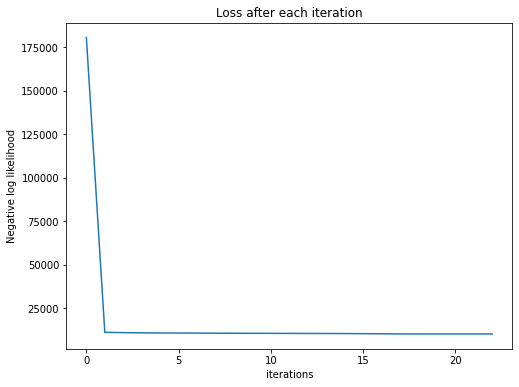

Model means:
[[ 5.00015899 19.8556918 ]
 [ 9.76671785 -9.90188685]
 [ 3.14197768  2.97072897]]

Actual means:
[[  3   3]
 [ 10 -10]
 [  5  20]]


In [7]:
class GaussianMixtureModel:
    def fit(self, X_train):
        self.pi = np.ones((Config.K,1)) / Config.K                                # pi_k
        idx = np.random.choice(np.arange(Config.N), Config.K)
        self.mu = X_train[idx] * 1.0 # choose K samples randomly from dist
        self.cov = np.array([np.eye(Config.D) for i in range(Config.K)]) # init K covs to identity
        
        nll = []
        for i in range(Config.iterations):
            loss = self.em_one_iteration(X_train)
            nll.append(loss)
            if len(nll) > 1 and np.abs(loss - nll[-2]) < Config.eps:
                break
        return nll
    
    # helpers
    def prob(self, X_nd, k): # (examples, k) -> [P(example1 | k), P(example2|k), ..]
        mu_1d = self.mu[k:k+1]
        cov_dd = self.cov[k]
        z_nd = X_nd - mu_1d
        A_nd = (z_nd @ np.linalg.inv(cov_dd))
        z_n  = (A_nd * z_nd).sum(axis=1)
        p_n  = (2*np.pi) ** (- Config.D / 2) * np.linalg.det(cov_dd) ** -.5 * np.exp(-.5 * z_n)
        return p_n

    def getGamma(self, X_nd):
        g_kn = np.array([
            self.pi[k, 0] * self.prob(X_nd, k)
            for k in range(Config.K)
        ]) # (k n)
        denom = g_kn.sum(axis=0, keepdims=True)
        denom[denom == 0.0] = 1
        g_kn /= denom # sum over clusters (k) must be one

        return g_kn, denom
    
    def em_one_iteration(self, X_nd):
        """Performs one iteration of the EM algorithm for gaussian mixture model
        Args
            * X_nd is an np.array with n examples, each of d dimensions
        Function
            * updates Params.mu, Params.cov and Params.pi
        """
        g_kn, denom = self.getGamma(X_nd)

        # N_k is gamma summed over n
        N_k1 = g_kn.sum(axis=1, keepdims=True) # shape (k,1)

        # new mu is examples averaged over gamma
        self.mu = np.matmul(g_kn, X_nd) / N_k1
        self.pi = N_k1 / Config.N

        # new mean is used to calculate new cov
        # calculate cov as E[x-mu] but over dist of reponse coeff
        for k in range(Config.K):
            g_n1 = g_kn[k:k+1].T
            z_nd = X_nd - self.mu[k:k+1]
            self.cov[k] = ((g_n1 * z_nd).T @ z_nd) / N_k1[k]

        # return log likelihood
        neg_log_likelihood = - np.log(denom).sum()
        return neg_log_likelihood

model = GaussianMixtureModel()
nll = model.fit(X_train)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(nll)
plt.xlabel('iterations')
plt.ylabel('Negative log likelihood')
plt.title('Loss after each iteration')
plt.show()

print("Model means:")
print(model.mu)
print()
print("Actual means:")
print(Actual.mu)

## Plotting learned distributions

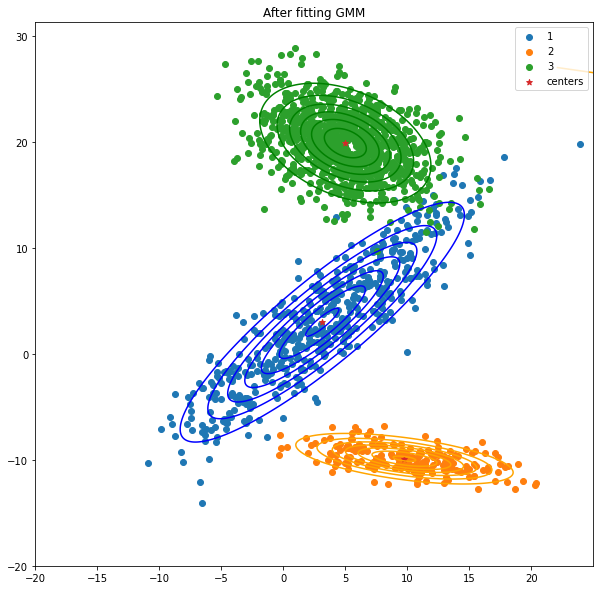

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
parts = np.cumsum([0] + Actual.sizes)

x_grid = np.arange(-20, 25, .02)
y_grid = np.arange(-20, 27, .02)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
colors = ['green', 'orange', 'blue']
       
for k in range(Config.K):
    x = X_train[parts[k]:parts[k+1]]
    ax.scatter(x[:,0], x[:,1], label=str(k+1))
    z_grid = scipy.stats.multivariate_normal(model.mu[k], model.cov[k]).pdf(coordinates).reshape(x_grid.shape)
    ax.contour(x_grid, y_grid, z_grid, colors=colors[k])
    
ax.scatter(model.mu[:,0], model.mu[:,1], marker='*', label='centers')
ax.set_title('After fitting GMM')
plt.legend();

# Parzen Window and K-means on the same custom data
Run K-Means and Parzen Window/Kernel density estimation on dataset generated in question 2 and compare the results with EM algorithm. Try different window sizes and different kernels for Kernel density estimation. Compare it with histogram based density estimation.

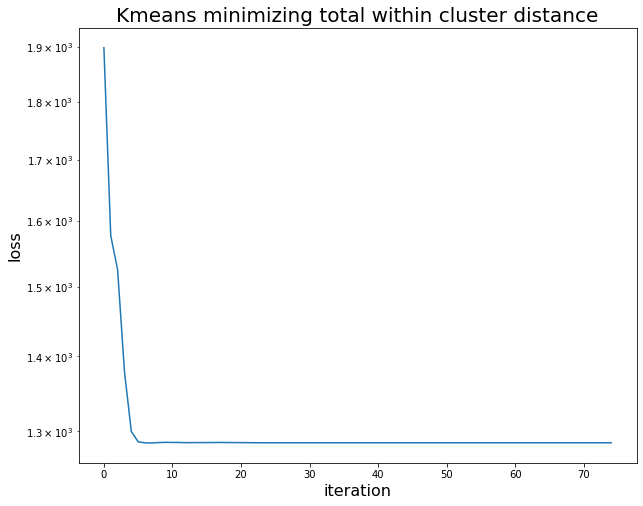

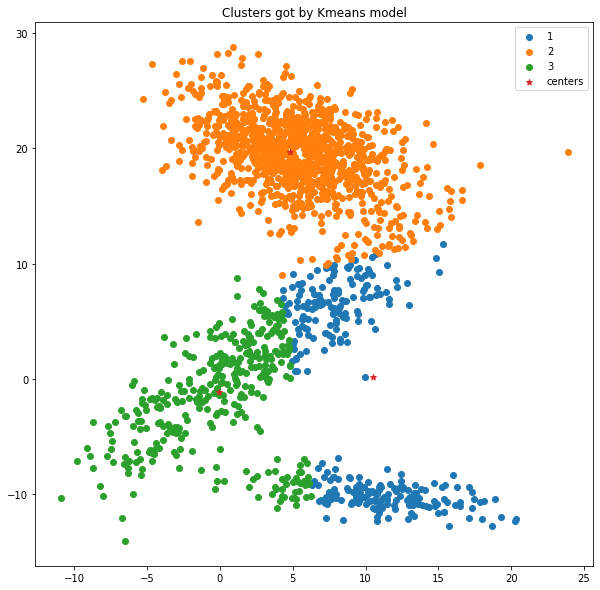

In [9]:
model = Kmeans()
losses = model.fit(X_train)
model.plot(losses, display_means=False)
labels = model.predict(X_train)

# plotting clusters got by model
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['blue', 'green', 'orange']
       
for k in range(Config.K):
    x = X_train[labels == k]
    ax.scatter(x[:,0], x[:,1], label=str(k+1))
    
ax.scatter(model.mu[:,0], model.mu[:,1], marker='*', label='centers')
ax.set_title('Clusters got by Kmeans model')
plt.legend();

In [10]:
def gaussianKernel(z_mtd, h): # z = (x - xi) / h of shape (m, t, d) m train ex, t for predict arg, d = Config.d
    z_mt = np.linalg.norm(z_mtd, axis=2)
    phi_mt = (2*np.pi) ** (Config.D / 2) * np.exp(- z_mt**2 / 2)
    phi_t  = phi_mt.mean(axis=0) / h ** Config.D
    return phi_t

def windowKernel(z_mtd, h):
    phi_mt = np.prod(z_mtd**2 <= .25, axis=2) # reduce d
    phi_t  = phi_mt.mean(axis=0) / h ** Config.D  # reduce m
    return phi_t

class ParzenWindow:
    def __init__(self, X_train, h, kernel='gaussian'):
        self.X = X_train
        self.h = h
        if kernel.lower() == 'gaussian':
            self.kernel = gaussianKernel
        else:
            self.kernel = windowKernel
            
    def predict(self, X_t):
        z_mtd = (X_t - self.X[:,None,:]) / self.h
        phi_t = self.kernel(z_mtd, self.h)
        return phi_t

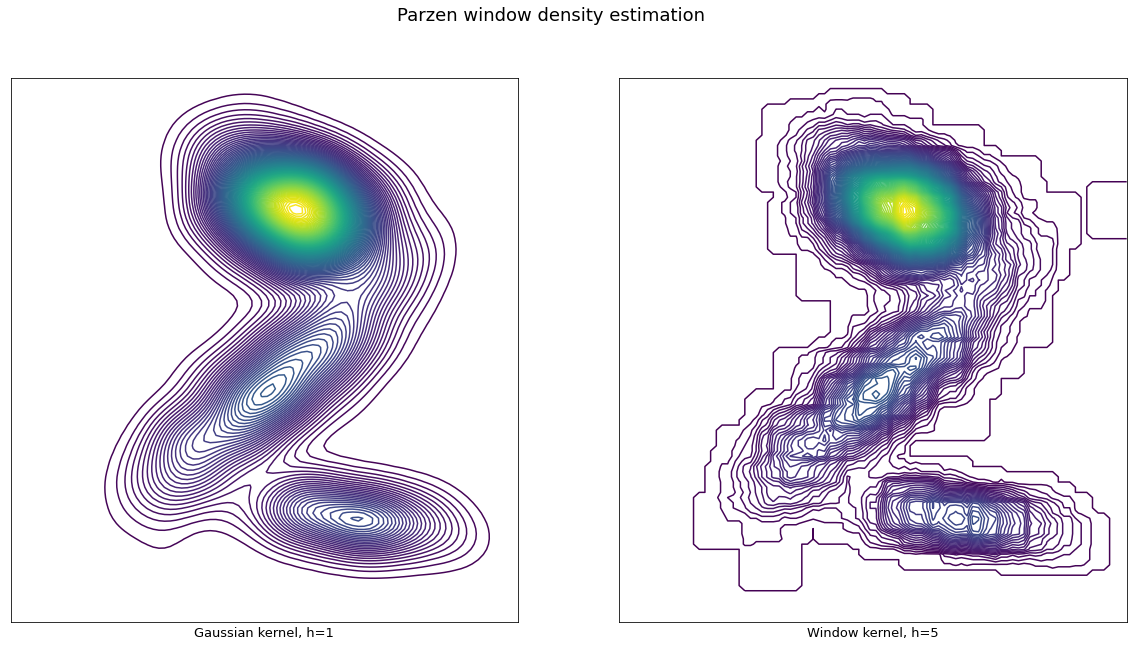

In [11]:
x_grid = np.arange(-20, 25, .5)
y_grid = np.arange(-20, 33, .5)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

model_gk = ParzenWindow(X_train, 2, 'gaussian')
density_g = model_gk.predict(coordinates).reshape(x_grid.shape)

model_wk = ParzenWindow(X_train, 5, 'window')
density_w = model_wk.predict(coordinates).reshape(x_grid.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Parzen window density estimation', fontsize=18)

ax1.contour(x_grid, y_grid, density_g, levels=np.linspace(density_g.min(), density_g.max(), num=100))
ax1.set_xlabel('Gaussian kernel, h=1', fontsize=13)
ax1.set(xticks=[], yticks=[])
ax2.contour(x_grid, y_grid, density_w, levels=np.linspace(density_w.min(), density_w.max(), num=100))
ax2.set_xlabel('Window kernel, h=5', fontsize=13)
ax2.set(xticks=[], yticks=[]);

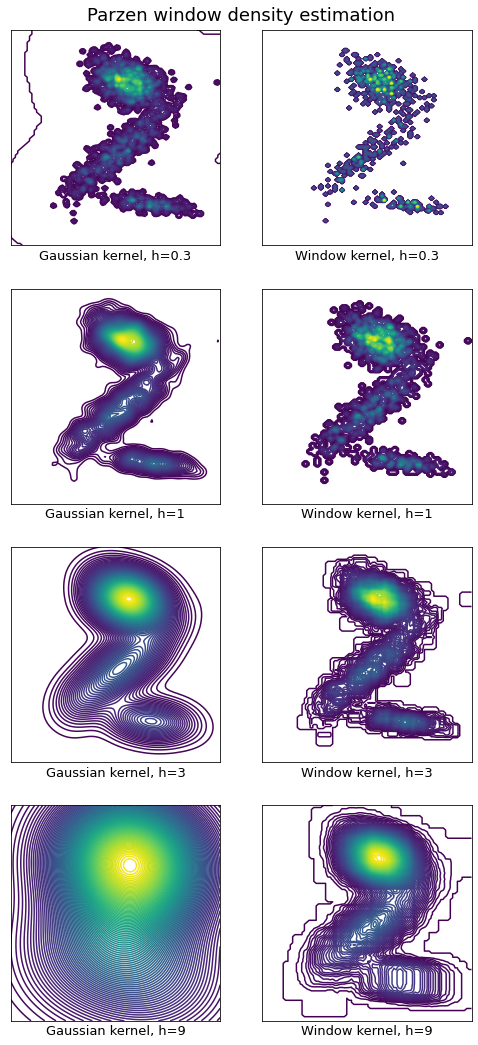

In [12]:
h_list = [0.3, 1, 3, 9]

fig, axs = plt.subplots(len(h_list), 2, figsize=(8, 16), gridspec_kw=dict(left=0.1, right=0.9, bottom=0.1, top=0.96))
plt.subplots_adjust(top=0.8)
fig.suptitle('Parzen window density estimation', fontsize=18)

for i, h in enumerate(h_list):
    model_gk = ParzenWindow(X_train, h, 'gaussian')
    density_g = model_gk.predict(coordinates).reshape(x_grid.shape)

    model_wk = ParzenWindow(X_train, h, 'window')
    density_w = model_wk.predict(coordinates).reshape(x_grid.shape)

    ax1, ax2 = axs[i,0], axs[i,1]
    ax1.contour(x_grid, y_grid, density_g, levels=np.linspace(density_g.min(), density_g.max(), num=100))
    ax1.set_xlabel(f'Gaussian kernel, h={h}', fontsize=13)
    ax1.set(xticks=[], yticks=[])
    ax2.contour(x_grid, y_grid, density_w, levels=np.linspace(density_w.min(), density_w.max(), num=100))
    ax2.set_xlabel(f'Window kernel, h={h}', fontsize=13)
    ax2.set(xticks=[], yticks=[]);
plt.show()

- As the window size increases, the density function becomes smoother and smoother. 
- Small window sizes => density function changes over small changes in position
- Large window sizes => even if we add points in a small region, a larger surrounding will have its density function value changed because of the large window size. The contour plot is a graphical representation of the same.


## GD GMM
- $\pi_k \in [0, 1]$ and $\sum\pi_k = 1$ then we declare a unconstrained variable $\xi_k$ such that $\pi = softmax(\xi)$
- The covariance matrices must be positive semidefinite. so we declare unconstrained matrices $M_k$ such that $\sum_k^{-1} = M_kM_k^T$

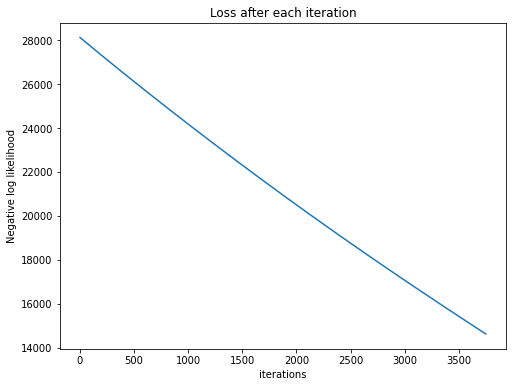

Model means:
[[ 9.56550783 17.95945598]
 [ 4.56785114 15.78477678]
 [ 6.97719713 18.4234213 ]]

Actual means:
[[  3   3]
 [ 10 -10]
 [  5  20]]
[[2.89094286]
 [0.40089697]
 [4.20816017]]


In [13]:
np.random.seed(42)
class GaussianMixtureModelGrad:
    def fit(self, X_train):
        self.si = np.zeros((Config.K,1))                                # pi_k
        # pi is softmax(si)
        
        idx = np.random.choice(np.arange(Config.N), Config.K)
        self.mu = X_train[idx] * 1.0 # choose K samples randomly from dist
#       #  correct mu
#         self.mu = np.array([[3,3], [10, -10], [5, 20]]).astype(np.float32)
        self.precision = np.array([np.random.randn(Config.D, Config.D) for i in range(Config.K)]) # init K covs to identity
        self.eta = 2e-3/Config.N
        
        nll = []
        for i in range(Config.iterations*50):
            loss = self.gd_one_iteration(X_train)
            nll.append(loss)
        return nll
    
    # helpers
    def prob(self, X_nd, k): # (examples, k) -> [P(example1 | k), P(example2|k), ..]
        mu_1d = self.mu[k:k+1]
#         inv_cov_dd = self.precision[k] @ self.precision[k].T
        inv_cov_dd = np.linalg.inv(Actual.cov[k])
        z_nd = X_nd - mu_1d
        A_nd = z_nd @ inv_cov_dd
        z_n  = (A_nd * z_nd).sum(axis=1)
        p_n  = (2*np.pi) ** (- Config.D / 2) * np.linalg.det(inv_cov_dd) ** .5 * np.exp(-.5 * z_n)
        return p_n

    def getGamma(self, X_nd):
        g_kn = np.array([
            np.exp(self.si[k, 0]) * self.prob(X_nd, k)
            for k in range(Config.K)
        ]) # (k n)
        denom = g_kn.sum(axis=0, keepdims=True)
        denom[denom == 0.0] = 1
        g_kn /= denom # sum over clusters (k) must be one

        return g_kn, denom
    
    def gd_one_iteration(self, X_nd):
        """Performs one iteration of the gradient descent for gaussian mixture model
        Args
            * X_nd is an np.array with n examples, each of d dimensions
        Function
            * updates Params.mu, Params.cov and Params.pi
        """
        g_kn, denom = self.getGamma(X_nd)

        # N_k is gamma summed over n
        N_k1 = g_kn.sum(axis=1, keepdims=True) # shape (k,1)

        # new mu is examples averaged over gamma
        for k in range(Config.K):
            z_nd = X_nd - self.mu[k:k+1]
            g_n1 = g_kn[k:k+1].T
#             inv_cov = self.precision[k] @ self.precision[k].T            
            inv_cov = np.linalg.inv(Actual.cov[k])
            delta_mu = g_n1.T @ (inv_cov @ z_nd.T).T
            
            # delta_cov = .5 * (inv_cov @ ((g_n1 * z_nd).T @ z_nd) @ inv_cov - N_k1[k] * inv_cov)
#             delta_precision = np.linalg.inv(self.precision[k].T) * N_k1[k] - self.precision[k] @ ((g_n1 * z_nd).T @ z_nd)
            
#             self.precision[k] += self.eta * delta_precision
            self.mu[k:k+1]  += self.eta * delta_mu

        delta_si = N_k1 
        self.si += self.eta * delta_si
        
        # return log likelihood
        neg_log_likelihood = - np.log(denom).sum()
        return neg_log_likelihood

model = GaussianMixtureModelGrad()
nll = model.fit(X_train)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(nll)
plt.xlabel('iterations')
plt.ylabel('Negative log likelihood')
plt.title('Loss after each iteration')
plt.show()

print("Model means:")
print(model.mu)
print()
print("Actual means:")
print(Actual.mu)

print(model.si)

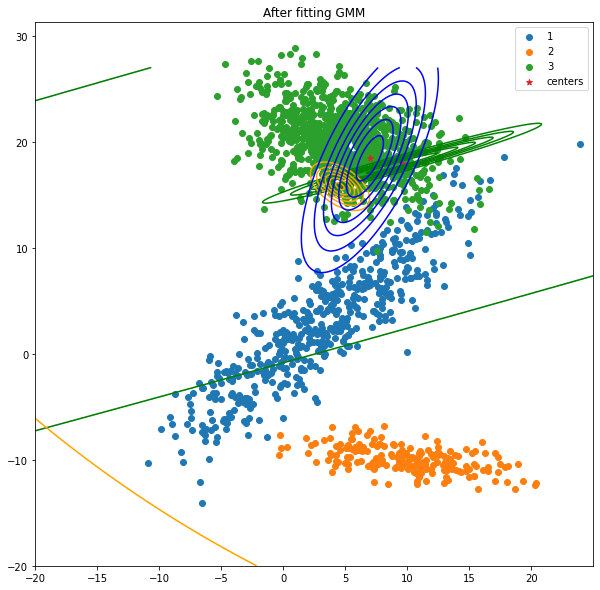

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
parts = np.cumsum([0] + Actual.sizes)

x_grid = np.arange(-20, 25, .02)
y_grid = np.arange(-20, 27, .02)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
colors = ['green', 'orange', 'blue']
       
for k in range(Config.K):
    x = X_train[parts[k]:parts[k+1]]
    ax.scatter(x[:,0], x[:,1], label=str(k+1))
    cov = np.linalg.inv(model.precision[k] @ model.precision[k].T)
    z_grid = scipy.stats.multivariate_normal(model.mu[k], cov).pdf(coordinates).reshape(x_grid.shape)
    ax.contour(x_grid, y_grid, z_grid, colors=colors[k])
    
ax.scatter(model.mu[:,0], model.mu[:,1], marker='*', label='centers')
ax.set_title('After fitting GMM')
plt.legend();

In [15]:
nll[-10:]

[14645.892619211156,
 14642.69083918832,
 14639.489220479289,
 14636.287763098833,
 14633.086467061868,
 14629.885332383456,
 14626.684359078783,
 14623.483547163189,
 14620.282896652141,
 14617.082407561255]

In [16]:
Actual.cov

[array([[34., 30.],
        [30., 34.]]),
 array([[15.54769466, -2.56515107],
        [-2.56515107,  1.45230534]]),
 array([[13.5       , -4.33012702],
        [-4.33012702,  8.5       ]])]